In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
from torchsummary import summary
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
import os
from utils.training import train_model
from utils.datasets import DatasetLoader
from models.CAM_based_models import MTEXCNN, XCM
from feature_extraction.CAM import GradCAM, GradCAMPlusPlus
from utils.visualization import CAMFeatureMaps, map_activation_to_input

# Load data

In [2]:
# Load dataset

dataset_path = './data/UWaveGestureLibrary'
dataset = DatasetLoader(dataset_path)
train_data, test_data = dataset.load_to_df()

In [3]:
X_train, y_train, X_test, y_test = dataset.load_to_nparray()

In [4]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 3, 315)

(120,)

(320, 3, 315)

(320,)

## Create DataLoader

In [5]:
dataloaders, datasets_size = dataset.get_torch_dataset_loader_auto(4, 4)

# CAM-based models

## MTEX-CNN

In [6]:
net = MTEXCNN(X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net

MTEXCNN(
  (cnn_layers): Sequential(
    (conv_1): Conv2d(1, 16, kernel_size=(158, 1), stride=(1, 1))
    (relu_1): ReLU(inplace=True)
    (conv_2): Conv2d(16, 32, kernel_size=(79, 1), stride=(1, 1))
    (relu_2): ReLU(inplace=True)
    (conv_3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_3): ReLU(inplace=True)
    (view): View(3, 80)
    (conv_4): Conv1d(3, 64, kernel_size=(3,), stride=(1,))
    (relu_4): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (fc1): Linear(in_features=4992, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [7]:
summary(net, (1,315,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 158, 3]           2,544
              ReLU-2           [-1, 16, 158, 3]               0
            Conv2d-3            [-1, 32, 80, 3]          40,480
              ReLU-4            [-1, 32, 80, 3]               0
            Conv2d-5             [-1, 1, 80, 3]              33
              ReLU-6             [-1, 1, 80, 3]               0
              View-7                [-1, 3, 80]               0
            Conv1d-8               [-1, 64, 78]             640
              ReLU-9               [-1, 64, 78]               0
           Linear-10                   [-1, 32]         159,776
           Linear-11                    [-1, 8]             264
Total params: 203,737
Trainable params: 203,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## XCM

In [8]:
window_size = int(0.3*X_train.shape[2])
if window_size % 2 == 0:
    window_size -= 1

net1 = XCM(window_size, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net1

XCM(
  (conv_11): Conv2d(1, 16, kernel_size=(93, 93), stride=(1, 1), padding=(46, 46))
  (batchnorm_11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_12): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv_21): Conv1d(3, 16, kernel_size=(93,), stride=(1,), padding=(46,))
  (batchnorm_21): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_22): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  (conv_3): Conv1d(315, 32, kernel_size=(93,), stride=(1,), padding=(46,))
  (batchnorm_3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (glb_avg_pool): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)

In [9]:
summary(net1, (1,315,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 315, 3]         138,400
       BatchNorm2d-2           [-1, 16, 315, 3]              32
            Conv2d-3            [-1, 1, 315, 3]              17
            Conv1d-4              [-1, 16, 315]           4,480
       BatchNorm1d-5              [-1, 16, 315]              32
            Conv1d-6               [-1, 1, 315]              17
            Conv1d-7                [-1, 32, 4]         937,472
       BatchNorm1d-8                [-1, 32, 4]              64
         AvgPool1d-9                [-1, 32, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                    [-1, 8]             264
          Softmax-12                    [-1, 8]               0
Total params: 1,080,778
Trainable params: 1,080,778
Non-trainable params: 0
---------------------------

# Training

In [10]:
# from torch_lr_finder import LRFinder

# model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
# criterion = nn.CrossEntropyLoss()
# optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-6)

# lr_finder = LRFinder(model.double(), optimizer_ft, criterion)
# lr_finder.range_test(dataloaders['train'], val_loader=dataloaders['val'], end_lr=1e-3, num_iter=100, step_mode="exp")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

Epoch 0/19
----------
train Loss: 2.0795 Acc: 0.1500 Correct: 18.0
val Loss: 1.6937 Acc: 0.3781 Correct: 121.0


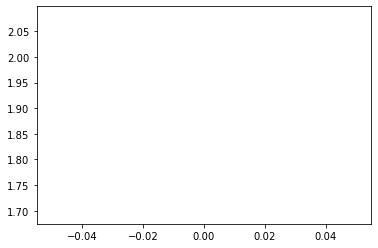

Epoch 1/19
----------
train Loss: 1.5476 Acc: 0.4333 Correct: 52.0
val Loss: 1.4400 Acc: 0.5031 Correct: 161.0


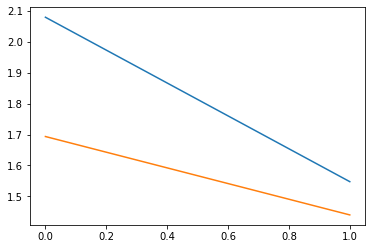

Epoch 2/19
----------
train Loss: 1.1549 Acc: 0.5667 Correct: 68.0
val Loss: 1.1687 Acc: 0.5594 Correct: 179.0


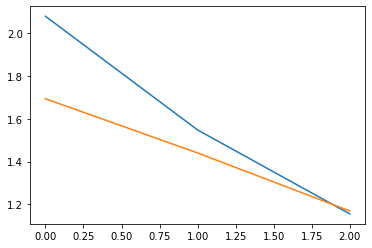

Epoch 3/19
----------
train Loss: 0.9404 Acc: 0.6500 Correct: 78.0
val Loss: 0.9433 Acc: 0.6344 Correct: 203.0


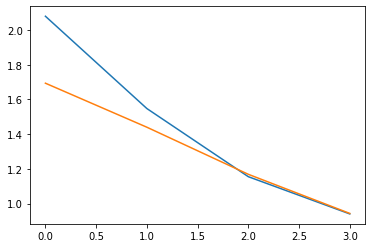

Epoch 4/19
----------
train Loss: 0.7096 Acc: 0.7667 Correct: 92.0
val Loss: 1.0819 Acc: 0.6625 Correct: 212.0


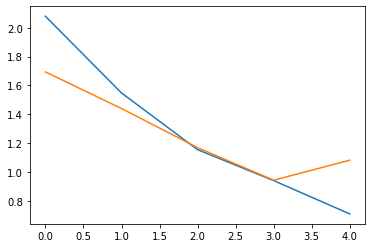

Epoch 5/19
----------
train Loss: 0.6118 Acc: 0.7833 Correct: 94.0
val Loss: 1.2420 Acc: 0.6469 Correct: 207.0


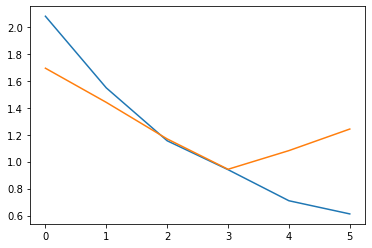

Epoch 6/19
----------
train Loss: 0.4987 Acc: 0.8083 Correct: 97.0
val Loss: 0.9720 Acc: 0.6813 Correct: 218.0


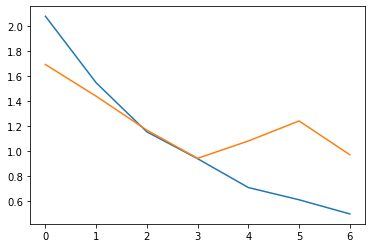

Epoch 7/19
----------
train Loss: 0.3879 Acc: 0.8750 Correct: 105.0
val Loss: 0.8902 Acc: 0.7312 Correct: 234.0


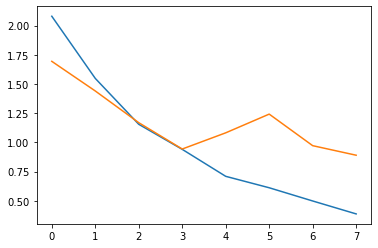

Epoch 8/19
----------
train Loss: 0.4446 Acc: 0.8583 Correct: 103.0
val Loss: 0.9283 Acc: 0.7188 Correct: 230.0


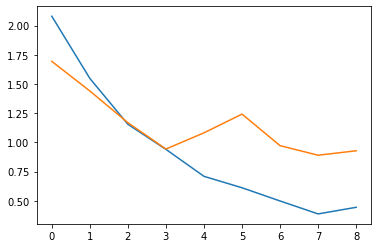

Epoch 9/19
----------
train Loss: 0.2707 Acc: 0.9167 Correct: 110.0
val Loss: 0.9769 Acc: 0.6969 Correct: 223.0


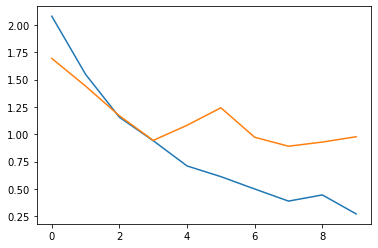

Epoch 10/19
----------
train Loss: 0.1726 Acc: 0.9667 Correct: 116.0
val Loss: 0.9569 Acc: 0.7219 Correct: 231.0


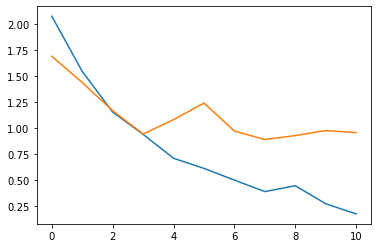

Epoch 11/19
----------
train Loss: 0.1260 Acc: 0.9750 Correct: 117.0
val Loss: 0.9670 Acc: 0.7219 Correct: 231.0


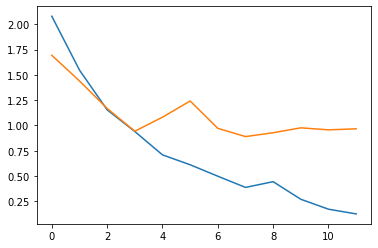

Epoch 12/19
----------
train Loss: 0.1124 Acc: 0.9750 Correct: 117.0
val Loss: 0.9827 Acc: 0.7188 Correct: 230.0


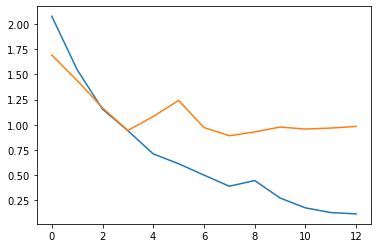

Epoch 13/19
----------
train Loss: 0.1026 Acc: 0.9750 Correct: 117.0
val Loss: 1.0049 Acc: 0.7219 Correct: 231.0


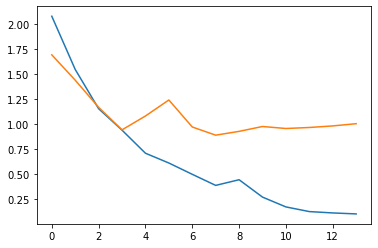

Epoch 14/19
----------
train Loss: 0.0962 Acc: 0.9750 Correct: 117.0
val Loss: 1.0126 Acc: 0.7312 Correct: 234.0


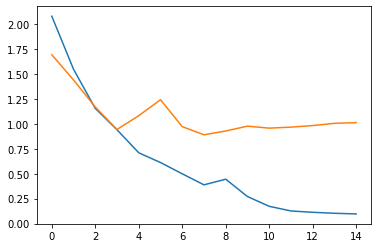

Epoch 15/19
----------
train Loss: 0.0880 Acc: 0.9833 Correct: 118.0
val Loss: 1.0283 Acc: 0.7219 Correct: 231.0


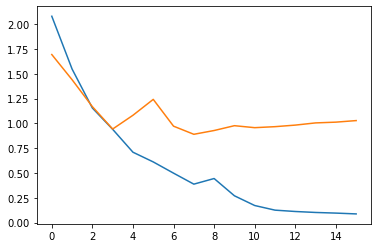

Epoch 16/19
----------
train Loss: 0.0822 Acc: 0.9833 Correct: 118.0
val Loss: 1.0475 Acc: 0.7188 Correct: 230.0


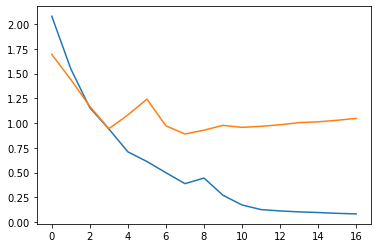

Epoch 17/19
----------
train Loss: 0.0777 Acc: 0.9833 Correct: 118.0
val Loss: 1.0569 Acc: 0.7250 Correct: 232.0


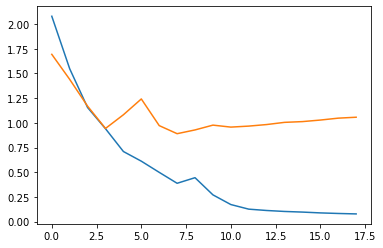

Epoch 18/19
----------
train Loss: 0.0717 Acc: 0.9833 Correct: 118.0
val Loss: 1.0696 Acc: 0.7219 Correct: 231.0


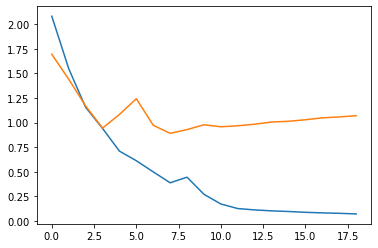

Epoch 19/19
----------
train Loss: 0.0674 Acc: 1.0000 Correct: 120.0
val Loss: 1.0763 Acc: 0.7219 Correct: 231.0


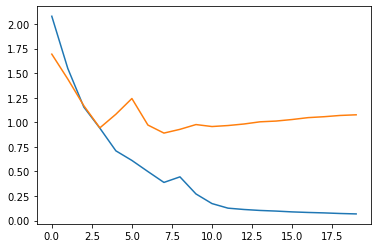

Training complete in 0m 14s
Best val Acc: 0.731250


MTEXCNN(
  (cnn_layers): Sequential(
    (conv_1): Conv2d(1, 16, kernel_size=(158, 1), stride=(1, 1))
    (relu_1): ReLU(inplace=True)
    (conv_2): Conv2d(16, 32, kernel_size=(79, 1), stride=(1, 1))
    (relu_2): ReLU(inplace=True)
    (conv_3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_3): ReLU(inplace=True)
    (view): View(3, 80)
    (conv_4): Conv1d(3, 64, kernel_size=(3,), stride=(1,))
    (relu_4): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (fc1): Linear(in_features=4992, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [11]:
# model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
model = net
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=4.5e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, datasets_size, 20)

## Feature Extraction

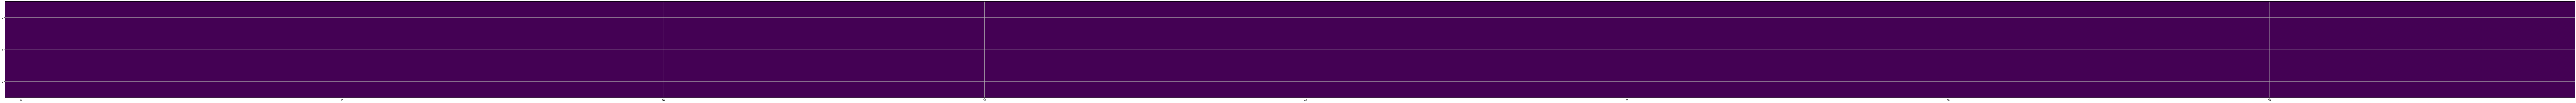

(3, 315)


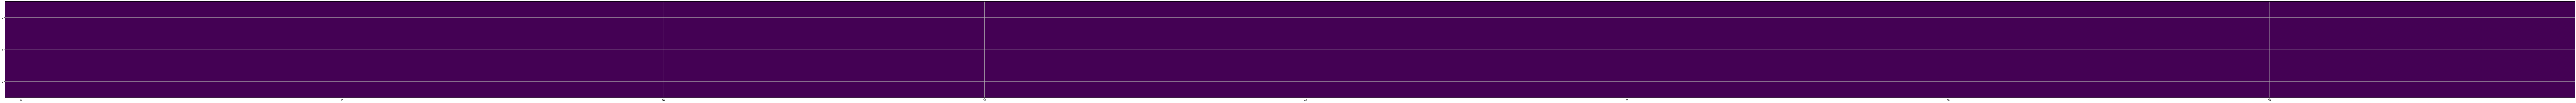

(3, 315)


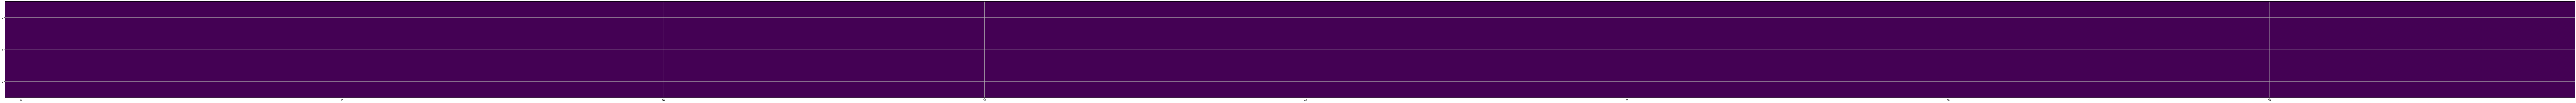

(3, 315)


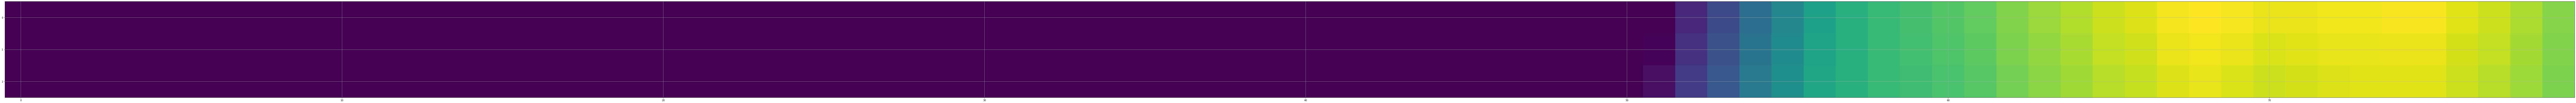

(3, 315)


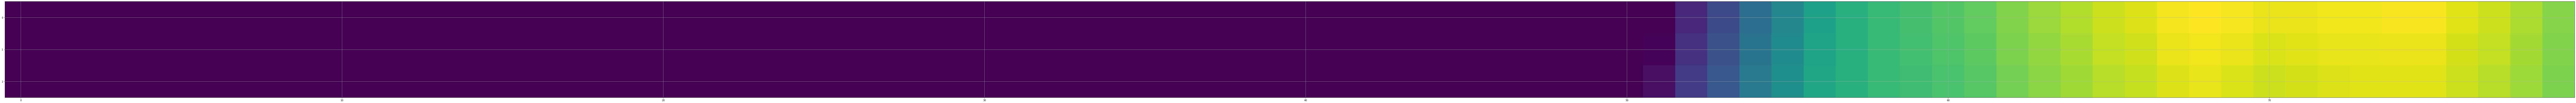

(3, 315)


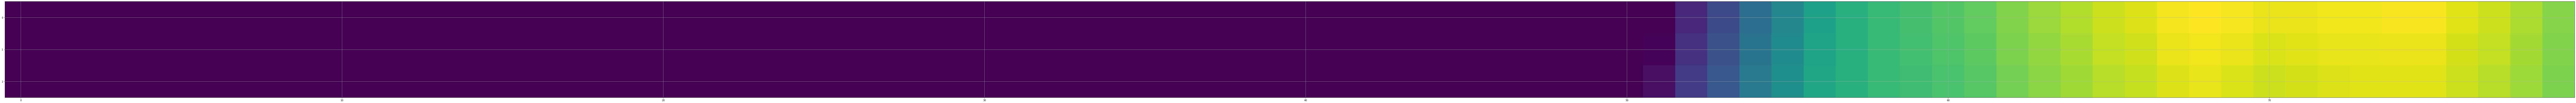

(3, 315)


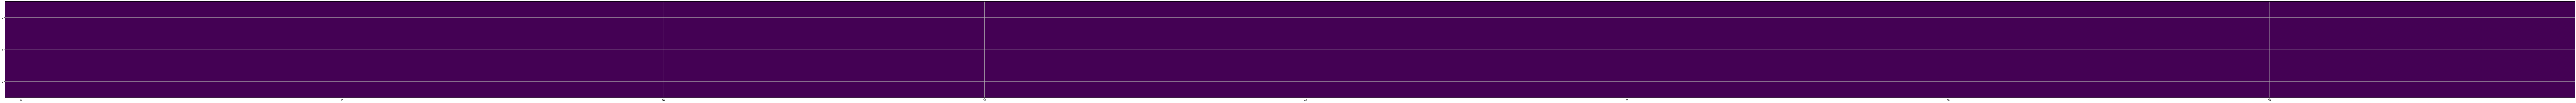

(3, 315)


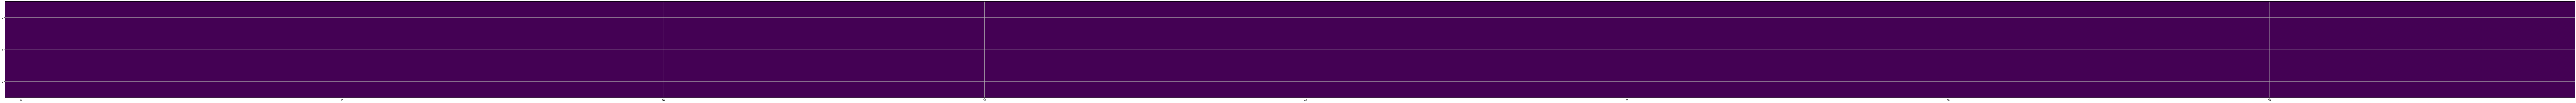

(3, 315)


In [25]:
feature_maps = CAMFeatureMaps(GradCAM)
feature_maps.load(model,'relu_3')
mask = {}
for i in range(len(np.unique(y_test))):
    mask[i] = feature_maps.show(X_test[0], i)

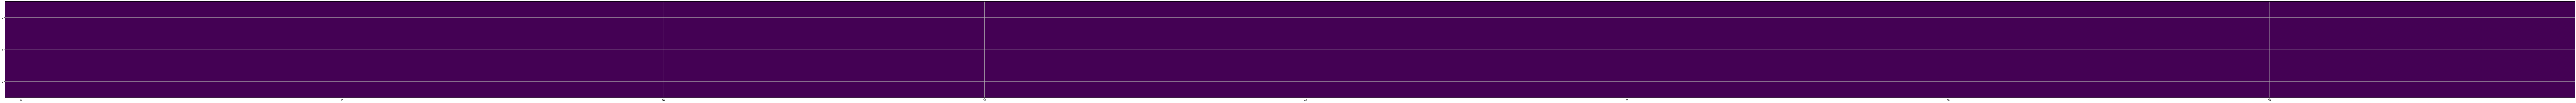

(3, 315)


In [27]:
mask = feature_maps.show(X_test[0], None)

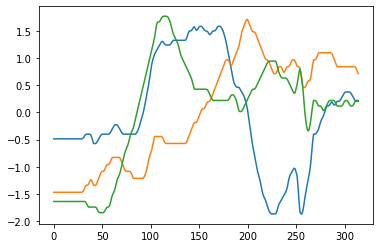

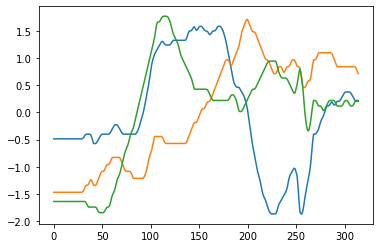

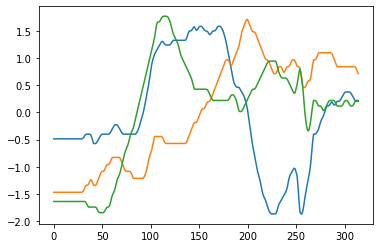

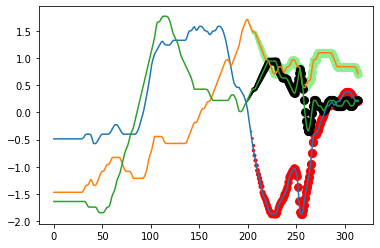

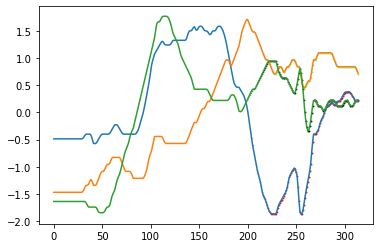

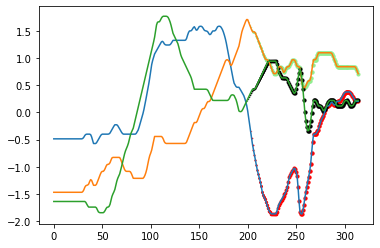

KeyboardInterrupt: 

In [21]:
for i in list(mask.keys()):
    map_activation_to_input(X_test[0], mask[i], 1e3)

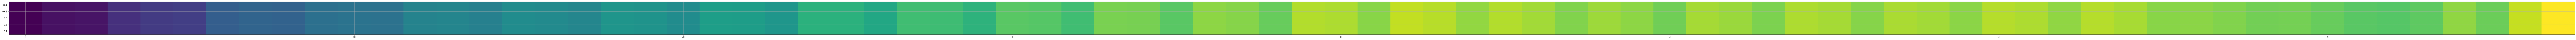

(3, 315)


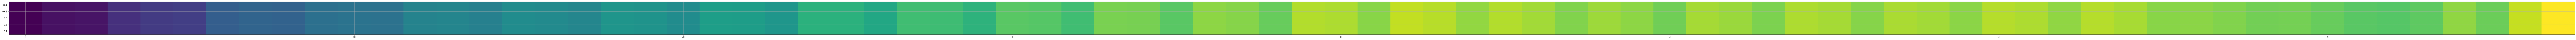

(3, 315)


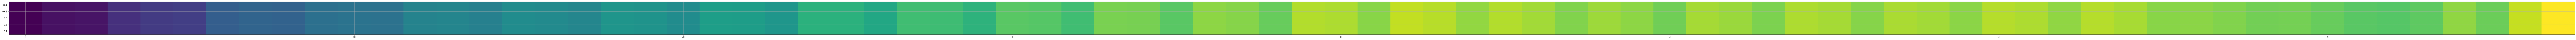

(3, 315)


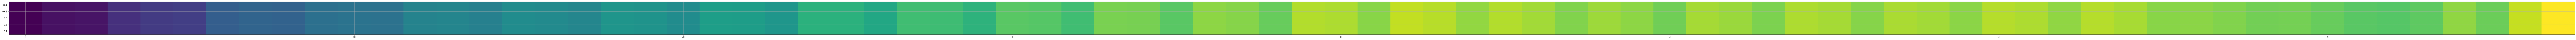

(3, 315)


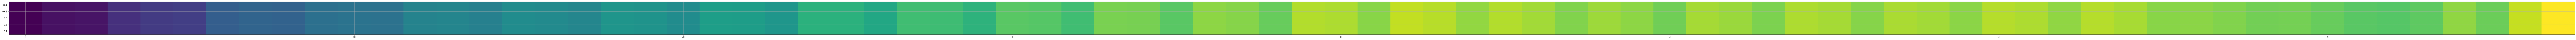

(3, 315)


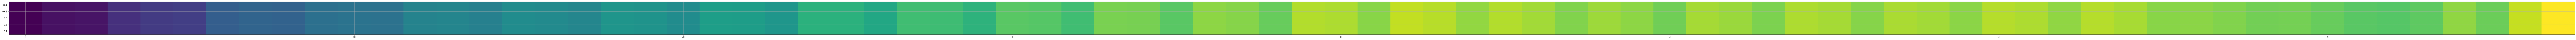

(3, 315)


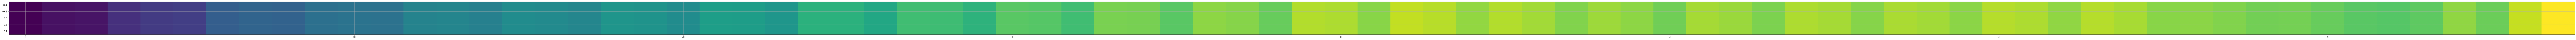

(3, 315)


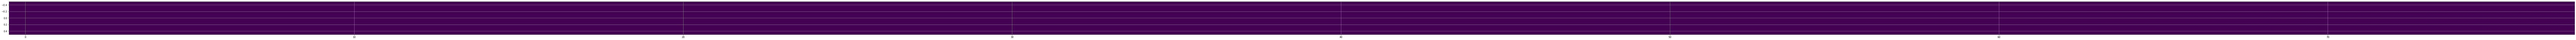

(3, 315)


In [24]:
feature_maps = CAMFeatureMaps(GradCAMPlusPlus)
feature_maps.load(model, 'relu_4')
mask1 = {}
for i in range(len(np.unique(y_test))):
    mask1[i] = feature_maps.show(X_test[0], i)

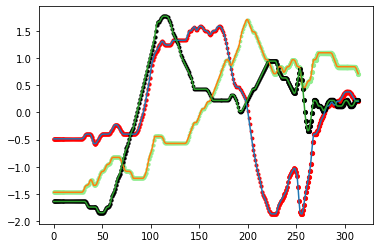

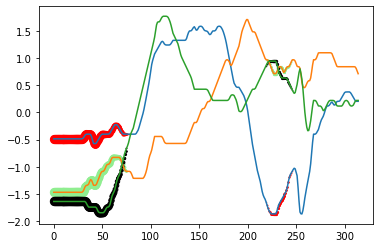

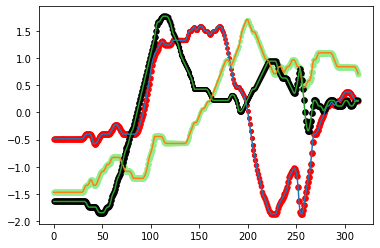

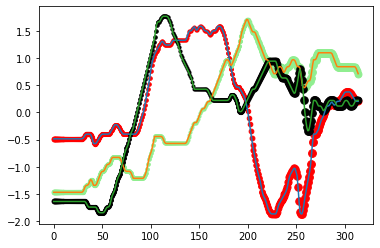

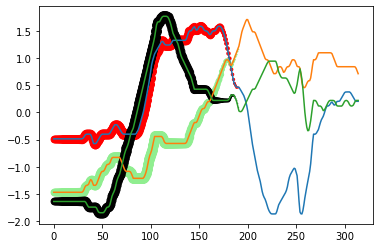

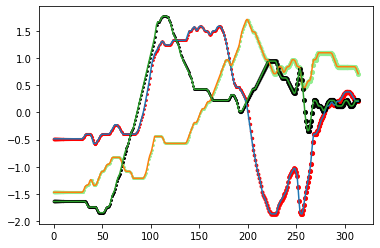

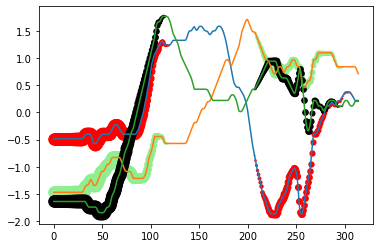

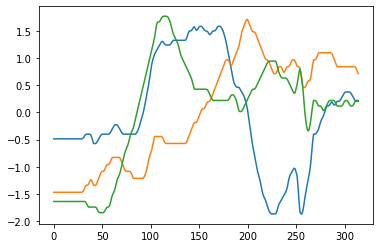

In [19]:
for i in list(mask1.keys()):
    map_activation_to_input(X_test[0], mask1[i], 1)